작성일 : 24.8.17 

#  각종 피쳐추가 
1. 유사 메뉴
- 몇번 나왔는지
- 품절률 
2. 상대 메뉴 

In [49]:
import os

if 'original_dir' not in globals() :
    original_dir = os.getcwd()
    original_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(original_dir)))))
    os.chdir(original_dir)
from setup.default import *
import scipy.stats as stats


In [50]:
menu_w_sold_out = pd.read_csv(os.getcwd()+'/data/preproc/main/feature_lab_v1/menu_w_soldout_w_first_menu.csv')
menu_w_sold_out['menu_no'] = menu_w_sold_out.groupby(['day', 'meal_time'])['day'].transform('size')
#menu_w_sold_out = menu_w_sold_out[['post_no','day','meal_time','course_no','first_menu','menu_no','is_soldout']]
target_w_sold_out = menu_w_sold_out[(menu_w_sold_out.menu_no>1)&
                     (menu_w_sold_out.day>='2023-06-01')&
                     (menu_w_sold_out.meal_time =='dinner')].reset_index(drop=True)

In [51]:
# 유사도가 높은 식품
first_menu_similarity = pd.read_csv(os.getcwd()+'/data/preproc/main/feature_lab_v1/first_menu_similarity.csv')

threshold = 0.7
first_menu_similarity = first_menu_similarity.loc[first_menu_similarity.sim_score>=threshold,['target_menu','menu','sim_score']]

In [52]:
target_w_sold_out['sim_menu'] = 0
target_w_sold_out['only_menu_2'] = 0
target_w_sold_out['only_menu_2_soldout'] = 0
target_w_sold_out['soldout_ratio'] = float('nan')

In [53]:
for i in tqdm(range(target_w_sold_out.shape[0])):
    target_menu, target_date, target_mt = target_w_sold_out.loc[i, ['first_menu', 'day', 'meal_time']]
    # 유사 메뉴 
    sim_menu = first_menu_similarity[first_menu_similarity.target_menu == target_menu].menu.tolist()
    # 구간 시작일 
    start_date = (datetime.strptime(target_date, "%Y-%m-%d") - relativedelta(months=6) + relativedelta(days=1)).strftime('%Y-%m-%d')
    if target_mt == 'lunch' : # lunch인 경우 (6달 전 ~ 어제)
        target_df1 = menu_w_sold_out[(menu_w_sold_out.day>=start_date) &         
                            (menu_w_sold_out.meal_time=='lunch') &
                            (menu_w_sold_out.day<target_date) &
                            (menu_w_sold_out.first_menu.isin(sim_menu))
                            ]
    # dinner only (6달 전 ~ 오늘 점심)
    target_df_dinner_only = menu_w_sold_out[(menu_w_sold_out.day>=start_date) & 
                        (menu_w_sold_out.day<=target_date)&
                        (menu_w_sold_out.meal_time=='dinner') &
                        ((menu_w_sold_out.day!=target_date)|(menu_w_sold_out.meal_time!='dinner')) &
                        (menu_w_sold_out.first_menu.isin(sim_menu))
                        ]    
    # 전체 (점심 +저녁 포함)
    target_df = menu_w_sold_out[(menu_w_sold_out.day>=start_date) & 
                        (menu_w_sold_out.day<=target_date)&
                        #(menu_w_sold_out.meal_time=='dinner') &
                        ((menu_w_sold_out.day!=target_date)|(menu_w_sold_out.meal_time!='dinner')) &
                        (menu_w_sold_out.first_menu.isin(sim_menu))
                        ] 


    sim_menu = len(target_df) # 몇번 나왔는지?
    # 품절률 계산용 
    only_menu_2 = (target_df['menu_no'] >= 2).sum() # 메뉴 2개 이상 나온 경우
    only_menu_2_soldout = ((target_df['menu_no'] >= 2) & target_df['is_soldout']).sum() # 메뉴 2개 이상 나왔는데 품절
    if only_menu_2>=3 :
        soldout_ratio = only_menu_2_soldout/only_menu_2
    else :
        soldout_ratio = float('nan')

    target_w_sold_out.loc[i, ['sim_menu', 'only_menu_2', 'only_menu_2_soldout', 'soldout_ratio']] = sim_menu, only_menu_2, only_menu_2_soldout, soldout_ratio

100%|██████████| 372/372 [00:00<00:00, 514.88it/s]


In [54]:
#target_w_sold_out['soldout_ratio'].fillna(target_w_sold_out['soldout_ratio'].median(), inplace=True)

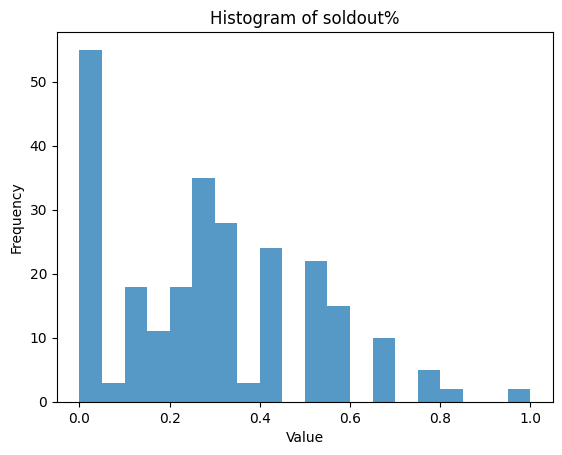

In [55]:
import matplotlib.pyplot as plt

# 히스토그램 그리기
target_w_sold_out['soldout_ratio'].plot(kind='hist', bins=20, range=(0, 1), alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of soldout%')
plt.show()


In [68]:
#pd.mertarget_w_sold_out,


target_w_sold_out_c = target_w_sold_out[['day','meal_time','course_no','sim_menu','only_menu_2','only_menu_2_soldout','soldout_ratio']].copy()
target_w_sold_out_c.rename(columns = {\
    'course_no':'course_no_c',
    'sim_menu':'sim_menu_c',
    'only_menu_2':'only_menu_2_c',
    'only_menu_2_soldout':'only_menu_2_soldout_c',
    'soldout_ratio':'soldout_ratio_c'
},inplace=True)

In [71]:
target_w_sold_out_fin = pd.merge(
    target_w_sold_out,
    target_w_sold_out_c,
    how='left',
    on =['day','meal_time']
    )
target_w_sold_out_fin = target_w_sold_out_fin[target_w_sold_out_fin.course_no!=target_w_sold_out_fin.course_no_c]

In [73]:
target_w_sold_out_fin.to_csv(original_dir+'/data/preproc/main/feature_lab_v1/menu_w_soldout_w_soldout_ratio.csv',index=False)